<img style="float:left" src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/a7/IE_Business_School_logo.svg/1200px-IE_Business_School_logo.svg.png?20200427113546" width="200"/>

<img style="float:center" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSqGMDcA1qUJJkieZOUCXnmnhKR-BytUqN-lq8j9jdTwOG2TM1gjI__eHZiMlQiIlfBVw&usqp=CAU" width="970"/>

* [1. Import libraries](#1)
  * [1.1 Functions creation](#1.1)
* [2. Import datasets](#2)
  * [2.1 Actually import files](#2.1)
* [3. Modeling: RandomForestRegressor](#3)
    * [3.1 Model 01: Complete model](#3.1)
    * [3.2 Model 02: Non-correlation features model](#3.2)
    * [3.3 Model 03: New features model](#3.3) 
    * [3.4 Model 04: Non-Facturado model](#3.4)
* [4. Modeling: XGBoost](#4)
    * [4.1 Model 05: Non-Facturado model](#4.1)
* [5. Modeling: LightGBM](#5)
    * [5.1 Model 06: Non-Facturado model](#5.1)
* [6. Conclusions](#6)
* [7. Annex](#7)

<a id='0'></a>
# Inditex - Sales Forecasting

This project was developed by Group 03 in the MBD April intake in 2022 as a Capstone project.

The initial data and task was given by Inditex, but outside data have been also used as a complement. This notebook only includes the modeling stage, the dataset production can be found on the other notebook.

<a id='1'></a>
## 1. Import libraries
The libraries which will be used are imported. They will also be configured if needed.

In [ ]:
## Import libraries

# Import pandas
import pandas as pd

# Import numpy
import numpy as np

# Import sklearn related
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.linear_model import LinearRegression
import lightgbm as lgb

# Import date related
from datetime import datetime

# Set random seed
rndm_seed = 97

# Import seaborn
import seaborn as sns

# Import matplotlib
import matplotlib.pyplot as plt

<a id='1.1'></a>
### 1.1. Functions creation

After this, some functions will be created which will be used throughout the project:
 - **get_train_data**: Function to get the correct data before training.
 - **get_feature_importance**: Function to get graphically each feature importance for the model.
 - **discard_highly_correlated**: Function to eliminate variables that are correlated in absolute values, above the threshold established.
 - **extract_variables**: Function to grab the best hyperparameters from the Random Grid Search after transforming the "gscv_01.cv_results_" into a string.
 - **hist_uds_error**: Function to see the error of the models (and it´s confidence interval) compared with a histogram of the variable to predict.
 - **plot_true_vs_pred_scatter**: This function takes in two inputs: the true values (y_test) and the predicted values (y_pred) and plots the distribution of true values versus predicted values along with a regression line.
 - **plot_true_vs_pred_histogram**: Plot a histogram to compare the distribution of true values and predicted values.

In [ ]:
def get_train_data(df, col_names, features_n):
    """
    Function to get the correct data before training. The inputs are:
    - df: complete numpy traning set
    - col_names: the names of the columns of the numpy dataframe
    - features_n: list of columns to select for the final training set
    """
    
    ## General steps
    
    # Get indices for columns
    feature_indices = [col_names.index(feature) for feature in features_n]
    
    # Get matrix to train
    X_train_n = df[:, feature_indices]
    
    # Check number of indices when training
    print("This model has " + str(X_train_n.shape[1]) + " features")

    # Return result
    return X_train_n

In [ ]:
def get_feature_importance(importances, feature_names):
    """
    Function to print the features importance of a classifier based on the coefficient values or another type of importance.
    - importances: a structure with the importance for each feature
    - feature_names: the name of each feature
    """
    return pd.DataFrame({'variable': feature_names, # Feature names
                         'coefficient': importances # Feature Coeficients
                    }) \
    .round(decimals=4) \
    .sort_values('coefficient', ascending=False) \
    .style.bar(color=['green', 'red'], align='zero')

In [ ]:
def discard_highly_correlated(df, threshold=0.9):
    """
    Function to eliminate variables that are correlated in absolute values above the threshold established.
    """
    
    # Create correlation matrix
    corr_matrix = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find index of feature columns with correlation greater than threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    # Drop features 
    df_discarded = df.drop(df[to_drop], axis=1)
    
    # List of the columns we finally use:
    to_mantain = list(df_discarded.columns)
    
    return to_drop, to_mantain


In [ ]:
def extract_variables(string):

    """
    Function to grab the best hyperparameters from the Random Grid Search after transforming the "gscv_01.cv_results_" into a string.
    """

    # Extract the variables inside the parentheses
    variables = string.split("(")[1].split(")")[0]

    # Split the variables by ","
    variables = variables.split(",")

    # Initialize a dictionary to hold the variable names and values
    variables_dict = {}

    # Iterate over the variables and add them to the dictionary
    for variable in variables:
        name, value = variable.strip().split("=")
        if value[0] == "'" and value[-1] == "'":
            value = value[1:-1]
        elif name == "max_features":
            if value == "sqrt":
                pass
            elif '.' in value:
                value = float(value)
        else:
            if value.isnumeric():
                value = int(value)
        variables_dict[name] = value

    max_depth = variables_dict.get("max_depth")
    max_features = variables_dict.get("max_features")
    n_estimators = variables_dict.get("n_estimators")
    
    return max_depth, max_features, n_estimators

In [ ]:
def hist_uds_error(df, error, ci):

  """
    Function to see the error of the models (and it´s confidence interval) compared with a histogram of the variable to predict.
  """

  sns.histplot(data = df, x = 'UDS_VENDIDAS_TOTAL_daily', kde=True, stat='density', color='blue')
  
  # Add a red line for the specific point
  plt.axvline(x=error*-1, color='red', linestyle='--')
  
  # Add the confidence interval as a shaded area
  plt.fill_betweenx(y=plt.ylim(), x1=((error*-1)+(ci*-1)), x2=((error*-1)+(ci)), color='grey', alpha=0.5)
  
  # Add a title and labels
  plt.title("Histogram of Uds Vendidas Total & Error of regressor")
  plt.xlabel("Uds Vendidas Total")
  plt.ylabel("Frequency")
  
  # Show the plot
  return plt.show()

In [ ]:
def plot_true_vs_pred_scatter(y_test, y_pred):
    
    """
    This function takes in two inputs: the true values (y_test) and the predicted values (y_pred) 
    and plots the distribution of true values versus predicted values along with a regression line.

    """
    # Converting the pandas series to a numpy array
    y_test_plot = y_test.values
    
    # Fitting a linear regression model on the true and predicted values
    reg = LinearRegression().fit(y_test_plot.reshape(-1, 1), y_pred)
        
    # Plotting the true values, predicted values and the regression line
    plt.figure(figsize=(15, 10))
    plt.scatter(y_test_plot, y_test_plot, alpha=0.5, label='True Values', color='blue')
    plt.scatter(y_test_plot, y_pred, alpha=0.5, label='Predicted Values', color='red')
    plt.plot(y_test_plot, reg.predict(y_test_plot.reshape(-1, 1)), color='green', label='Regression Line')
    plt.legend()
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('Distribution of True Values vs. Predicted Values')
    plt.show()

In [ ]:
def plot_true_vs_pred_histogram(y_test, y_pred):
    """
    Plot a histogram to compare the distribution of true values and predicted values.

    """
    # Create a figure with specified size
    plt.figure(figsize=(15, 10))
    # Plot the histogram of the true values with blue color and specified opacity
    plt.hist(y_test, bins=100, alpha=0.5, label='True Values', color='blue')
    # Plot the histogram of the predicted values with red color and specified opacity
    plt.hist(y_pred, bins=100, alpha=0.5, label='Predicted Values', color='red')
    # Add a legend to the plot
    plt.legend()
    # Label the x-axis
    plt.xlabel('Values')
    # Label the y-axis
    plt.ylabel('Frequency')
    # Add a title to the plot
    plt.title('Distribution of True Values vs. Predicted Values')
    # Display the plot
    plt.show()

<a id='2'></a>
## 2. Import datasets
The data will now be read from the csv we created in the Premodeling part. We devided the porcess in Premodeling and Modeling parts because of the large running time the first part takes.
There are four different files (all tabular in .csv formats):

<a id='2.1'></a>
### 2.1. Actually import files
The four files will be read separetly.

In [ ]:
## Read csv files

# Read data_train file
data_train = pd.read_csv("./data_train.csv")

# Read data_test file
data_test = pd.read_csv("./data_test.csv")

# Read y_train_pd file
y_train_pd = pd.read_csv("./y_train_pd.csv")

# Read y_test_pd file
y_test_pd = pd.read_csv("./y_test_pd.csv")

First of all we will have to drop the index column that is in all datasets.

In [ ]:
## Drop index column (Unnamed: 0)

# data_train file
data_train = data_train.drop(['Unnamed: 0'], axis=1)

# data_test file
data_test = data_test.drop(['Unnamed: 0'], axis=1)

# y_train_pd file
y_train_pd = y_train_pd.drop(['Unnamed: 0'], axis=1)

# y_test_pd file
y_test_pd = y_test_pd.drop(['Unnamed: 0'], axis=1)

For UDS_VENDIDAS_TOTAL_daily, we can see that there are some negative values. In particular, they are always equal to -1. We decided to remove them.

In [ ]:
# First we merge the data:
df_inditex_train = pd.merge(data_train, y_train_pd, left_index=True, right_index=True)
df_inditex_test = pd.merge(data_test, y_test_pd, left_index=True, right_index=True)

# Then we just keep the positive values for UDS_VENDIDAS_TOTAL_daily:
data_train = df_inditex_train[(df_inditex_train["UDS_VENDIDAS_TOTAL_daily"] >= 0)]
data_test = df_inditex_test[(df_inditex_test["UDS_VENDIDAS_TOTAL_daily"] >= 0)]

# Finally we separate again the datastes:
y_train_pd = data_train.pop('UDS_VENDIDAS_TOTAL_daily').to_frame()
y_test_pd = data_test.pop('UDS_VENDIDAS_TOTAL_daily').to_frame()

<a id='3'></a>
## 3. Modeling: RandomForestRegressor

In this part, four different **RandomForestRegressor** models will be trained. 
Before starting to model, some basic parameters will be set, which will be used in all or most models.

The **paramsgrid** dictionary sets the hyperparameters to be tested in the grid search. It includes random_state, n_estimators, max_depth, and max_features. Here we inputed many diferent hyperparameter as in the following steps we will get the optimal ones.  

The **model** is defined as an instance of RandomForestRegressor with the random_state parameter set to rndm_seed, defined when importing libraries.

The **gscv** is an instance of RandomizedSearchCV, which is a grid search method for hyperparameter tuning. It uses **model** as the estimator and **paramsgrid** as the parameter distribution to search over. The scoring method is specified with the scoring_method parameter and the search will refit the model using RMSE. The number of folds for **cross-validation** is set to 5 with the cv parameter, and **return_train_score** is set to return training scores. The **verbose** parameter determines the amount of output to display during the grid search, and **n_jobs** specifies the number of CPU cores to use for parallel processing.

Four different "metrics" will be reported through this process:

 - **Mean RMSE on train and validation** sets: this will be used to compare the performance of different models (mean RMSE on validation set) and to see whether the model is overfitting (mean RMSE on training vs validation sets).
 - **Standard deviation on training and validation** sets: to see how "confident" we are on the training and validation metrics.

Apart from this, the traing time will be recorded.

Finally, the y_train array is converted to a 1D array for computational issues. Then, the **gscv.fit** method fits the grid search on the training data X_train and y_train_1D.

In [ ]:
## Stating general options for modeling

# Define scoring method
scoring_method = ['neg_root_mean_squared_error','neg_mean_absolute_percentage_error']

# Define how much info we want from scikit learn
verbose_amount = 2

# Number of cores to use
n_jobs_use = -1

Before modeling, the data will be converted to a numpy array, as this is what sklearn takes in easily.

In [ ]:
## Converting data to numpy

# Save column names for later
col_names = list(data_train.columns)

# Save variable as dataframe
data_train_df = data_train

# Transform to numpy
X_train = np.array(data_train)
X_test = np.array(data_test)

# Transform target variable
y_train = np.array(y_train_pd)
y_test = np.array(y_test_pd)

<a id='3.1'></a>
### 3.1. Model 01: Complete Model

This model will be run with all the possible variables from the dataset. It will be trained with different parameters and  criterias to get the best possible result.

In [ ]:
## Get data to train model

# State features to use
features_01 = ['DIAS_HASTA_SALDO_std', 'FACTURADO_std',
       'UDS_COMPRADAS_std', 'PRECIO_std', 'LATITUD_std', 'LONGITUD_std',
       'num_hol_std', 'Shops_in_city_std', 'Population_city_std',
       'GDP_Per_cap_city_std', 'Satelite_city_std', 'Summer_tourist_city_std',
       'habs_per_shop_city_std', 'Shops_in_country_std',
       'Population_country_std', 'GDP_Per_cap_country_std',
       'habs_per_shop_country_std', 'days_overlap_precovid_std',
       'days_overlap_strongcovid_std', 'days_overlap_mediumcovid_std',
       'days_overlap_postcovid_std', 'Jan_in_period_std', 'Feb_in_period_std',
       'Mar_in_period_std', 'Apr_in_period_std', 'May_in_period_std',
       'Jun_in_period_std', 'Jul_in_period_std', 'Aug_in_period_std',
       'Sep_in_period_std', 'Oct_in_period_std', 'Nov_in_period_std',
       'Dec_in_period_std', 'Number_of_sat&sun_std', 'TEMP_AVG_std',
       'TEMP_MED_std', 'TEMP_MAX_std', 'TEMP_MIN_std', 'PRCP_AVG_std',
       'PRCP_MED_std', 'PRCP_MAX_std', 'PRCP_MIN_std', 'PRCP_SUM_std',
       'WDSP_AVG_std', 'WDSP_MED_std', 'WDSP_MAX_std', 'WDSP_MIN_std',
       'FACTURADO_daily_std', 'num_hol_daily_std',
       'days_overlap_precovid_daily_std', 'days_overlap_strongcovid_daily_std',
       'days_overlap_mediumcovid_daily_std',
       'days_overlap_postcovid_daily_std', 'Number_of_sat&sun_daily_std',
       'PRCP_SUM_daily_std', 'Num_shops_per_art_std',
       'COD_COMPRADOR_1_ohe_std', 'COD_COMPRADOR_2_ohe_std',
       'COD_COMPRADOR_3_ohe_std', 'COD_COMPRADOR_4_ohe_std',
       'COD_COMPRADOR_5_ohe_std', 'MERCADO_1_ohe_std', 'MERCADO_2_ohe_std',
       'MERCADO_3_ohe_std', 'MERCADO_4_ohe_std', 'MERCADO_5_ohe_std',
       'MERCADO_6_ohe_std', 'MERCADO_7_ohe_std',
       'COD_TIPO_LOCALIZACION_1_ohe_std', 'COD_TIPO_LOCALIZACION_2_ohe_std',
       'COD_TIPO_LOCALIZACION_3_ohe_std', 'COD_TIPO_LOCALIZACION_4_ohe_std',
       'COD_TIPO_LOCALIZACION_5_ohe_std', 'COD_LOCALIZACION_te_std',
       'COD_TIPO_te_std', 'COD_SUBTIPO_te_std', 'COD_COLOR_te_std',
       'City_te_std', 'FECHA_PRIMERA_VENTA_year_te_std',
       'FECHA_PRIMERA_VENTA_month_te_std', 'FECHA_PRIMERA_VENTA_day_te_std',
       'FECHA_PRIMERA_VENTA_day_of_week_te_std',
       'FECHA_PRIMERA_VENTA_day_of_year_te_std',
       'FECHA_PRIMERA_VENTA_quarter_te_std',
       'FECHA_PRIMERA_VENTA_number_week_te_std',
       'FECHA_ULTIMA_VENTA_year_te_std', 'FECHA_ULTIMA_VENTA_month_te_std',
       'FECHA_ULTIMA_VENTA_day_te_std',
       'FECHA_ULTIMA_VENTA_day_of_week_te_std',
       'FECHA_ULTIMA_VENTA_day_of_year_te_std',
       'FECHA_ULTIMA_VENTA_quarter_te_std',
       'FECHA_ULTIMA_VENTA_number_week_te_std']

# Actually get features
X_train_01 = get_train_data(X_train, col_names, features_01)

This model has 92 features


The model is trained with the specified hyperparameters. The hyperparameter tuning is performed through a randomized search looking for the best hyperparameters using a specified scoring method and cross-validation method.

In [ ]:
## Train model

# Get start time of model
starttime_01 = datetime.now()

# Set parameters to test in the grid
paramsgrid_01 = {'random_state': [rndm_seed],
                 "n_estimators": [100, 500, 1000, 1500, 2000],
                 "max_depth": [5, 8, 10, 12, 15],
                 "max_features": ['sqrt', 0.2, 0.5, 0.7]}

# State model: Random Forest Regressor regression
model_01 = RandomForestRegressor(random_state=rndm_seed)

# State grid search
gscv_01 = RandomizedSearchCV(estimator=model_01,
                             param_distributions=paramsgrid_01,
                             scoring=scoring_method,
                             refit = 'neg_root_mean_squared_error',
                             cv = 5,
                             return_train_score=True, verbose = verbose_amount, n_jobs = n_jobs_use)

# Convert y_train to 1D array 
y_train_1D = np.ravel(y_train)

# Actually fit grid search
gscv_01.fit(X_train_01, y_train_1D)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=97),
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 8, 10, 12, 15],
                                        'max_features': ['sqrt', 0.2, 0.5, 0.7],
                                        'n_estimators': [100, 500, 1000, 1500,
                                                         2000],
                                        'random_state': [97]},
                   refit='neg_root_mean_squared_error', return_train_score=True,
                   scoring=['neg_root_mean_squared_error',
                            'neg_mean_absolute_percentage_error'],
                   verbose=2)

From the previous models trained, we will get the best results. This will help us understand which of these is the best model and also will provide us with the training and validation scores.

In [ ]:
## Get results from models (MSE)

# Get results variable
results_01 = gscv_01.cv_results_

# Get best model index
bestm_index = gscv_01.best_index_

# Print results #std_test_neg_mean_absolute_percentage_error
print("The total runtime for the model was: " + str(datetime.now() - starttime_01))
print("\nThe final model is: " + str(gscv_01.best_estimator_))
print("\nThe mean error on training for the best model is: " +
      format(results_01['mean_train_neg_root_mean_squared_error'][bestm_index]*-1, '.3f') + " +/- " + 
      format(results_01['std_train_neg_root_mean_squared_error'][bestm_index]*-1, '.3f'))
print("\nThe mean error on validation for the best model is: " +
      format(results_01['mean_test_neg_root_mean_squared_error'][bestm_index]*-1, '.3f') + " +/- " + 
      format(results_01['std_test_neg_root_mean_squared_error'][bestm_index]*-1, '.3f'))

The total runtime for the model was: 3:11:12.132898

The final model is: RandomForestRegressor(max_depth=12, max_features=0.5, n_estimators=500,
                      random_state=97)

The mean error on training for the best model is: 0.067 +/- -0.000

The mean error on validation for the best model is: 0.085 +/- -0.001


In order to see the error compared to the distribution of the target variable, we plot below the histogram of UDS_VENDIDAS_TOTAL. The red line is the error and the grey area is the confidence interval.

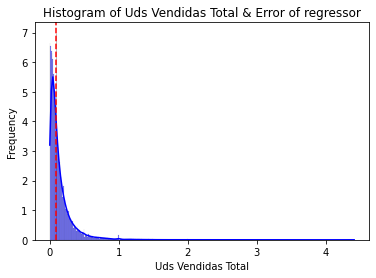

In [ ]:
hist_uds_error(y_test_pd, results_01['mean_test_neg_root_mean_squared_error'][bestm_index], results_01['std_test_neg_root_mean_squared_error'][bestm_index])

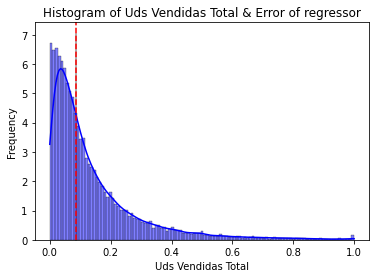

In [ ]:
hist_uds_error(y_test_pd.loc[y_test_pd["UDS_VENDIDAS_TOTAL_daily"]<=1], results_01['mean_test_neg_root_mean_squared_error'][bestm_index], results_01['std_test_neg_root_mean_squared_error'][bestm_index])

We need to get the best hyperparameters of the model so we can see the feature importance in the next step.

In [ ]:
max_depth, max_features, n_estimators = extract_variables(str(gscv_01.best_estimator_))

In the below graph, we can see the Feature importance that each variable has regarding the prediction of the target variable. The higher the value, the more important the feature.

In [ ]:
#Build model with final features
clf_01 = RandomForestRegressor(max_depth = max_depth, n_estimators = n_estimators, max_features = max_features, random_state = rndm_seed).fit(X_train_01, y_train_1D)

#Get feature importance
get_feature_importance(clf_01.feature_importances_, features_01)

,variable,coefficient
47,FACTURADO_daily_std,0.599000
1,FACTURADO_std,0.192300
33,Number_of_sat&sun_std,0.039400
0,DIAS_HASTA_SALDO_std,0.037300
73,COD_LOCALIZACION_te_std,0.009500
55,Num_shops_per_art_std,0.007700
2,UDS_COMPRADAS_std,0.007200
76,COD_COLOR_te_std,0.006900
52,days_overlap_postcovid_daily_std,0.005600
82,FECHA_PRIMERA_VENTA_day_of_year_te_std,0.005500


Now let´s take a look at the predictions of our model and the behaviour against the test dataset:

In [ ]:
y_pred_01 = clf_01.predict(data_test)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test_pd, y_pred_01))

print("RMSE on the test dataset: ", round(rmse,5))

RMSE on the test dataset:  0.08429


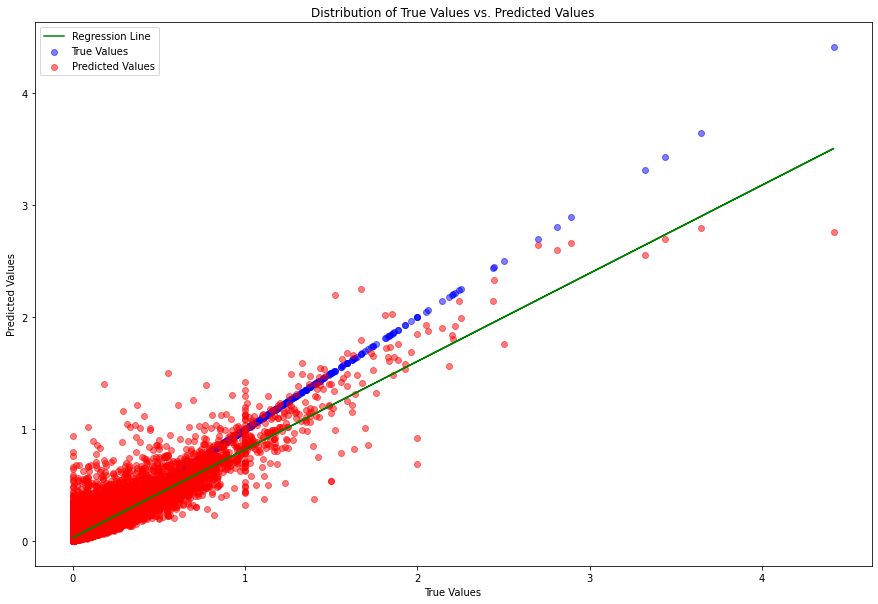

In [ ]:
plot_true_vs_pred_scatter(y_test_pd, y_pred_01)

If our model predicts with a 100% of accuracy, the green line (a regression for our predictions) should be equal to the blue line (the test values). We can observe that for this model, they appear to be quite similar. Actually, if we take out the predicted values at the right of the graph, we will probably see how the green line is even more close to the blue one. 

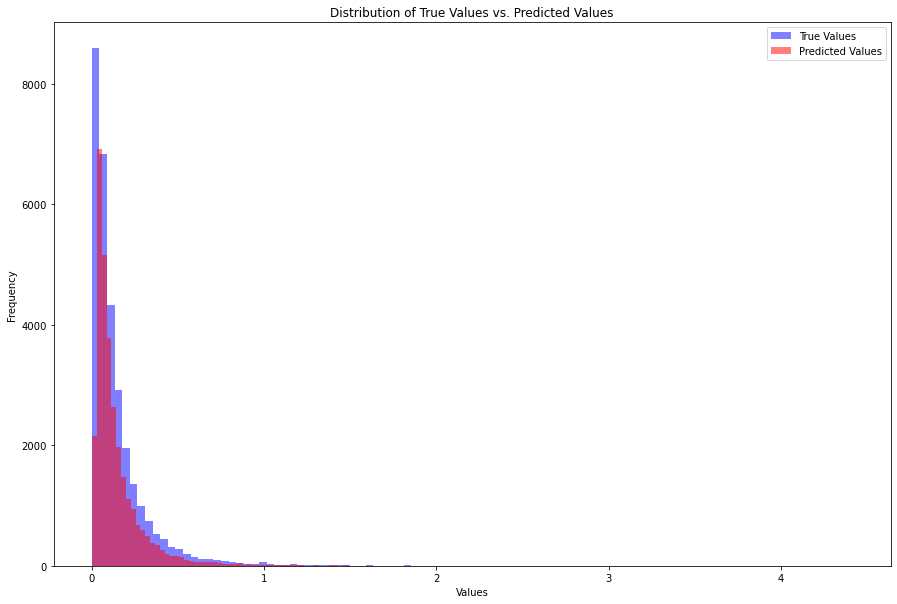

In [ ]:
plot_true_vs_pred_histogram(y_test_pd, y_pred_01)

We can observe that the distribution of our model is quite similar to the test dataset. This shows that our model is accurate.

### Conclusions for Model 01

The first model we developed is comprehensive, including all 92 variables in its analysis. The results are highly favorable, with a low error rate and a graphical representation that closely mirrors real-life data. This model would be a perfect fit for our business scenario.

However, our feature importance analysis revealed that the variable 'FACTURADO' has a significant weight. This could potentially lead to this variable overshadowing the significance of other variables in the model. This prompted us to explore alternative versions of the RandomForestRegressor to ensure a more balanced and accurate representation of the data. By taking this approach, we aim to maintain the favorable results achieved in the first model while considering the importance of all variables.

<a id='3.2'></a>
### 3.2. Model 02: Non-correlation features model

For this model we have selected a set of features to eliminate inter correlation between variables.

In [ ]:
discarded_columns, final_columns = discard_highly_correlated(data_train, threshold=0.9)

The columns discarded as per high correlation are:

In [ ]:
discarded_columns

['habs_per_shop_country_std',
 'Dec_in_period_std',
 'Number_of_sat&sun_std',
 'TEMP_MED_std',
 'days_overlap_mediumcovid_daily_std',
 'days_overlap_postcovid_daily_std',
 'PRCP_SUM_daily_std',
 'MERCADO_2_ohe_std',
 'MERCADO_6_ohe_std',
 'City_te_std',
 'FECHA_ULTIMA_VENTA_month_te_std',
 'FECHA_ULTIMA_VENTA_day_of_year_te_std',
 'FECHA_ULTIMA_VENTA_quarter_te_std']

And the finals columns used are:

In [ ]:
final_columns

['DIAS_HASTA_SALDO_std',
 'FACTURADO_std',
 'UDS_COMPRADAS_std',
 'PRECIO_std',
 'LATITUD_std',
 'LONGITUD_std',
 'num_hol_std',
 'Shops_in_city_std',
 'Population_city_std',
 'GDP_Per_cap_city_std',
 'Satelite_city_std',
 'Summer_tourist_city_std',
 'habs_per_shop_city_std',
 'Shops_in_country_std',
 'Population_country_std',
 'GDP_Per_cap_country_std',
 'days_overlap_precovid_std',
 'days_overlap_strongcovid_std',
 'days_overlap_mediumcovid_std',
 'days_overlap_postcovid_std',
 'Jan_in_period_std',
 'Feb_in_period_std',
 'Mar_in_period_std',
 'Apr_in_period_std',
 'May_in_period_std',
 'Jun_in_period_std',
 'Jul_in_period_std',
 'Aug_in_period_std',
 'Sep_in_period_std',
 'Oct_in_period_std',
 'Nov_in_period_std',
 'TEMP_AVG_std',
 'TEMP_MAX_std',
 'TEMP_MIN_std',
 'PRCP_AVG_std',
 'PRCP_MED_std',
 'PRCP_MAX_std',
 'PRCP_MIN_std',
 'PRCP_SUM_std',
 'WDSP_AVG_std',
 'WDSP_MED_std',
 'WDSP_MAX_std',
 'WDSP_MIN_std',
 'FACTURADO_daily_std',
 'num_hol_daily_std',
 'days_overlap_precovid_

In [ ]:
## Get data to train model

# State features to use
features_02 = final_columns

# Actually get features
X_train_02 = get_train_data(X_train, col_names, features_02)

This model has 79 features


The model is trained with the specified hyperparameters. The hyperparameter tuning is performed through a randomized search looking for the best hyperparameters using a specified scoring method and cross-validation method.

In [ ]:
## Train model

# Get start time of model
starttime_02 = datetime.now()

# Set parameters to test in the grid
paramsgrid_02 = {'random_state': [rndm_seed],
                 "n_estimators": [100, 500, 1000, 1500, 2000],
                 "max_depth": [5, 8, 10, 12, 15],
                 "max_features": ['sqrt', 0.2, 0.5, 0.7]}

# State model: Random Forest Regressor regression
model_02 = RandomForestRegressor(random_state=rndm_seed)

# State grid search
gscv_02 = RandomizedSearchCV(estimator=model_02,
                             param_distributions=paramsgrid_02,
                             scoring=scoring_method,
                             refit = 'neg_root_mean_squared_error',
                             cv = 5,
                             return_train_score=True, verbose = verbose_amount, n_jobs = n_jobs_use)

# Convert y_train to 1D array 
y_train_1D = np.ravel(y_train)

# Actually fit grid search
gscv_02.fit(X_train_02, y_train_1D)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=97),
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 8, 10, 12, 15],
                                        'max_features': ['sqrt', 0.2, 0.5, 0.7],
                                        'n_estimators': [100, 500, 1000, 1500,
                                                         2000],
                                        'random_state': [97]},
                   refit='neg_root_mean_squared_error', return_train_score=True,
                   scoring=['neg_root_mean_squared_error',
                            'neg_mean_absolute_percentage_error'],
                   verbose=2)

From the previous models trained, we will get the best results. This will help us understanding which of these is the best model and also will provide us the train and test score to compare them. 

In [ ]:
## Get results from models (MSE)

# Get results variable
results_02 = gscv_02.cv_results_

# Get best model index
bestm_index = gscv_02.best_index_

# Print results #std_test_neg_mean_absolute_percentage_error
print("The total runtime for the model was: " + str(datetime.now() - starttime_02))
print("\nThe final model is: " + str(gscv_02.best_estimator_))
print("\nThe mean error on training for the best model is: " +
      format(results_02['mean_train_neg_root_mean_squared_error'][bestm_index]*-1, '.3f') + " +/- " + 
      format(results_02['std_train_neg_root_mean_squared_error'][bestm_index]*-1, '.3f'))
print("\nThe mean error on validation for the best model is: " +
      format(results_02['mean_test_neg_root_mean_squared_error'][bestm_index]*-1, '.3f') + " +/- " + 
      format(results_02['std_test_neg_root_mean_squared_error'][bestm_index]*-1, '.3f'))

The total runtime for the model was: 9:42:44.556973

The final model is: RandomForestRegressor(max_depth=15, max_features=0.2, n_estimators=500,
                      random_state=97)

The mean error on training for the best model is: 0.057 +/- -0.000

The mean error on validation for the best model is: 0.085 +/- -0.002


In order to see the error compared to the distribution of the target variable, we plot below the histogram of UDS_VENDIDAS_TOTAL. The red line is the error and the grey area is the confidence interval.

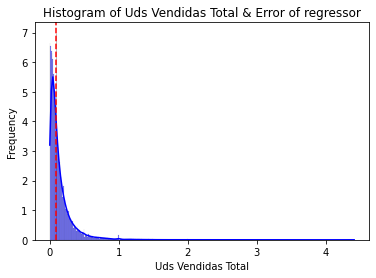

In [ ]:
hist_uds_error(y_test_pd, results_02['mean_test_neg_root_mean_squared_error'][bestm_index], results_02['std_test_neg_root_mean_squared_error'][bestm_index])

We need to get the best hyperparameters of the model so we can see the feature importance in the next step.

In [ ]:
max_depth, max_features, n_estimators = extract_variables(str(gscv_02.best_estimator_))

In the below graph, we can see the Feature importance that each variable has regarding the prediction of the target variable. The higher the value, the more important the feature.

In [ ]:
#Build model with final features
clf_02 = RandomForestRegressor(max_depth = max_depth, n_estimators = n_estimators, max_features = max_features, random_state = rndm_seed).fit(X_train_02, y_train_1D)

#Get feature importance
get_feature_importance(clf_02.feature_importances_, features_02)

,variable,coefficient
43,FACTURADO_daily_std,0.406400
1,FACTURADO_std,0.256300
0,DIAS_HASTA_SALDO_std,0.059200
64,COD_LOCALIZACION_te_std,0.022700
44,num_hol_daily_std,0.016400
6,num_hol_std,0.012500
2,UDS_COMPRADAS_std,0.012200
48,Num_shops_per_art_std,0.010800
45,days_overlap_precovid_daily_std,0.010200
67,COD_COLOR_te_std,0.009600


Now let´s take a look at the predictions of our model and the behaviour against the test dataset:

In [ ]:
y_pred_02 = clf_02.predict(data_test[final_columns])

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test_pd, y_pred_02))

print("RMSE on the test dataset: ", round(rmse,5))

RMSE on the test dataset:  0.08529


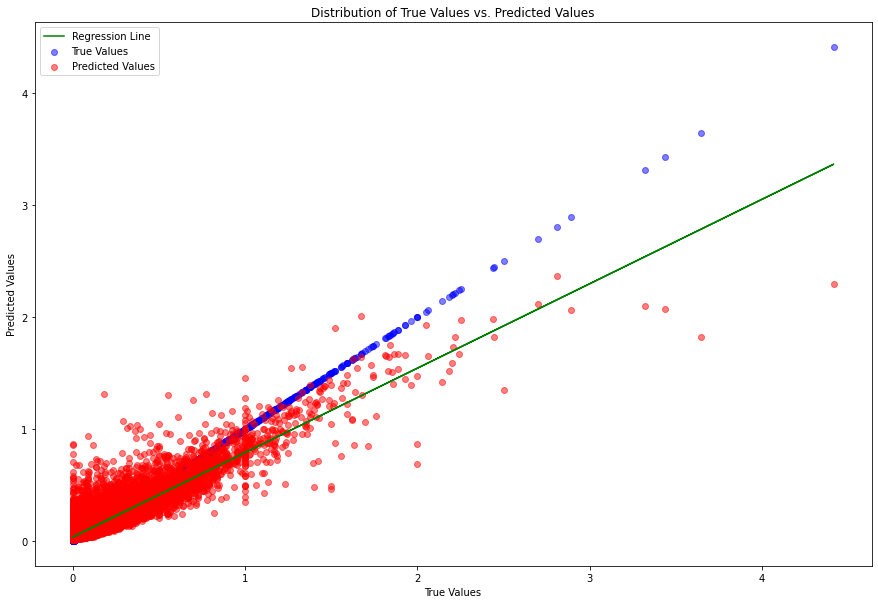

In [ ]:
plot_true_vs_pred_scatter(y_test_pd, y_pred_02)

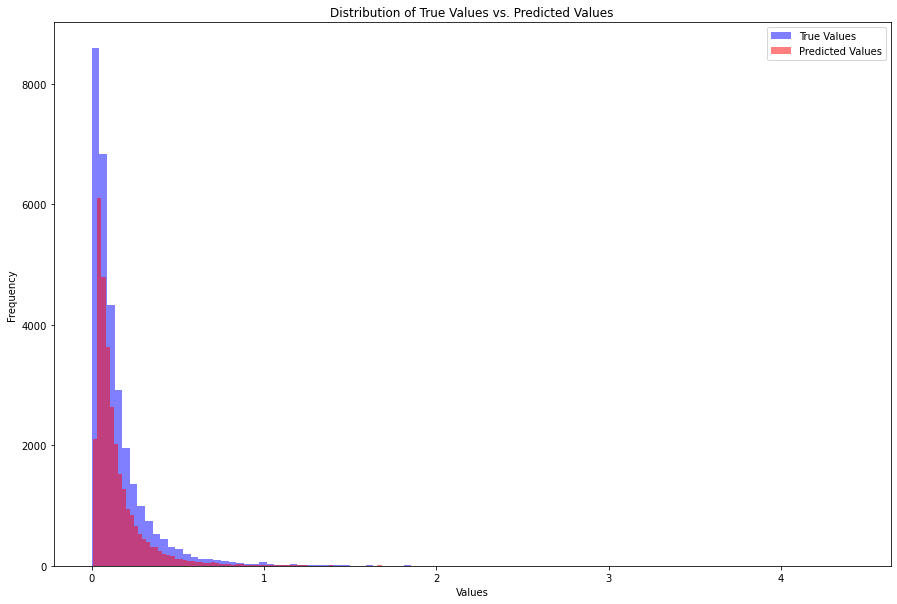

In [ ]:
plot_true_vs_pred_histogram(y_test_pd, y_pred_02)

Similarly to the small changes observed in the error, we can see that these graphs does not show major differences to the previous ones.

### Conclusions for Model 02

The second model was constructed with the objective of eliminating features that are highly correlated with each other. As a result, a total of 79 variables were included in this model, as opposed to the 92 features included in Model 01. Despite the favorable results achieved, with a low error rate and a graphical representation that closely matches real-life data, the performance of this model falls slightly short of that of Model 01.

Furthermore, the pattern of important features in this model is similar to that of Model 01. This leads us to the conclusion that eliminating features that could potentially introduce noise into the model did not result in improved performance compared to Model 01.

<a id='3.3'></a>
### 3.3. Model 03: New features model

For this model we have selected only the features that were created from external data or that were extracted from the original data. This is mainly to understand the importance of these new features for predicting the target variable.

In [ ]:
## Get data to train model

# State features to use
features_03 = ['num_hol_std', 'Shops_in_city_std', 'Population_city_std',
       'GDP_Per_cap_city_std', 'Satelite_city_std', 'Summer_tourist_city_std',
       'habs_per_shop_city_std', 'Shops_in_country_std',
       'Population_country_std', 'GDP_Per_cap_country_std',
       'habs_per_shop_country_std', 'days_overlap_precovid_std',
       'days_overlap_strongcovid_std', 'days_overlap_mediumcovid_std',
       'days_overlap_postcovid_std', 'Jan_in_period_std', 'Feb_in_period_std',
       'Mar_in_period_std', 'Apr_in_period_std', 'May_in_period_std',
       'Jun_in_period_std', 'Jul_in_period_std', 'Aug_in_period_std',
       'Sep_in_period_std', 'Oct_in_period_std', 'Nov_in_period_std',
       'Dec_in_period_std', 'Number_of_sat&sun_std', 'TEMP_AVG_std',
       'TEMP_MED_std', 'TEMP_MAX_std', 'TEMP_MIN_std', 'PRCP_AVG_std',
       'PRCP_MED_std', 'PRCP_MAX_std', 'PRCP_MIN_std', 'PRCP_SUM_std',
       'WDSP_AVG_std', 'WDSP_MED_std', 'WDSP_MAX_std', 'WDSP_MIN_std',
       'days_overlap_precovid_daily_std', 'days_overlap_strongcovid_daily_std',
       'days_overlap_mediumcovid_daily_std',  'num_hol_daily_std',
       'days_overlap_postcovid_daily_std', 'Number_of_sat&sun_daily_std',
       'PRCP_SUM_daily_std', 'Num_shops_per_art_std',
       'City_te_std', 'FECHA_PRIMERA_VENTA_year_te_std',
       'FECHA_PRIMERA_VENTA_month_te_std', 'FECHA_PRIMERA_VENTA_day_te_std',
       'FECHA_PRIMERA_VENTA_day_of_week_te_std',
       'FECHA_PRIMERA_VENTA_day_of_year_te_std',
       'FECHA_PRIMERA_VENTA_quarter_te_std',
       'FECHA_PRIMERA_VENTA_number_week_te_std',
       'FECHA_ULTIMA_VENTA_year_te_std', 'FECHA_ULTIMA_VENTA_month_te_std',
       'FECHA_ULTIMA_VENTA_day_te_std',
       'FECHA_ULTIMA_VENTA_day_of_week_te_std',
       'FECHA_ULTIMA_VENTA_day_of_year_te_std',
       'FECHA_ULTIMA_VENTA_quarter_te_std',
       'FECHA_ULTIMA_VENTA_number_week_te_std']

features_drop = ['DIAS_HASTA_SALDO_std', 'FACTURADO_std',
       'UDS_COMPRADAS_std', 'PRECIO_std', 'LATITUD_std', 'LONGITUD_std', 'FACTURADO_daily_std',
       'COD_COMPRADOR_1_ohe_std', 'COD_COMPRADOR_2_ohe_std',
       'COD_COMPRADOR_3_ohe_std', 'COD_COMPRADOR_4_ohe_std',
       'COD_COMPRADOR_5_ohe_std', 'MERCADO_1_ohe_std', 'MERCADO_2_ohe_std',
       'MERCADO_3_ohe_std', 'MERCADO_4_ohe_std', 'MERCADO_5_ohe_std',
       'MERCADO_6_ohe_std', 'MERCADO_7_ohe_std',
       'COD_TIPO_LOCALIZACION_1_ohe_std', 'COD_TIPO_LOCALIZACION_2_ohe_std',
       'COD_TIPO_LOCALIZACION_3_ohe_std', 'COD_TIPO_LOCALIZACION_4_ohe_std',
       'COD_TIPO_LOCALIZACION_5_ohe_std', 'COD_LOCALIZACION_te_std',
       'COD_TIPO_te_std', 'COD_SUBTIPO_te_std', 'COD_COLOR_te_std']

# Actually get features
X_train_03 = get_train_data(X_train, col_names, features_03)

This model has 64 features


The model is trained with the specified hyperparameters. The hyperparameter tuning is performed through a randomized search looking for the best hyperparameters using a specified scoring method and cross-validation method.

In [ ]:
## Train model

# Get start time of model
starttime_03 = datetime.now()

# Set parameters to test in the grid
paramsgrid_03 = {'random_state': [rndm_seed],
                 "n_estimators": [100, 500, 1000, 1500, 2000],
                 "max_depth": [5, 8, 10, 12, 15],
                 "max_features": ['sqrt', 0.2, 0.5, 0.7]}

# State model: Random Forest Regressor regression
model_03 = RandomForestRegressor(random_state=rndm_seed)

# State grid search
gscv_03 = RandomizedSearchCV(estimator=model_03,
                             param_distributions=paramsgrid_03,
                             scoring=scoring_method,
                             refit = 'neg_root_mean_squared_error',
                             cv = 5,
                             return_train_score=True, verbose = verbose_amount, n_jobs = n_jobs_use)

# Convert y_train to 1D array 
y_train_1D = np.ravel(y_train)

# Actually fit grid search
gscv_03.fit(X_train_03, y_train_1D)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=97),
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 8, 10, 12, 15],
                                        'max_features': ['sqrt', 0.2, 0.5, 0.7],
                                        'n_estimators': [100, 500, 1000, 1500,
                                                         2000],
                                        'random_state': [97]},
                   refit='neg_root_mean_squared_error', return_train_score=True,
                   scoring=['neg_root_mean_squared_error',
                            'neg_mean_absolute_percentage_error'],
                   verbose=2)

From the previous models trained, we will get the best results. This will help us understanding which of these is the best model and also will provide us the train and test score to compare them. 

In [ ]:
## Get results from models (MSE)

# Get results variable
results_03 = gscv_03.cv_results_

# Get best model index
bestm_index = gscv_03.best_index_

# Print results #std_test_neg_mean_absolute_percentage_error
print("The total runtime for the model was: " + str(datetime.now() - starttime_03))
print("\nThe final model is: " + str(gscv_03.best_estimator_))
print("\nThe mean error on training for the best model is: " +
      format(results_03['mean_train_neg_root_mean_squared_error'][bestm_index]*-1, '.3f') + " +/- " + 
      format(results_03['std_train_neg_root_mean_squared_error'][bestm_index]*-1, '.3f'))
print("\nThe mean error on validation for the best model is: " +
      format(results_03['mean_test_neg_root_mean_squared_error'][bestm_index]*-1, '.3f') + " +/- " + 
      format(results_03['std_test_neg_root_mean_squared_error'][bestm_index]*-1, '.3f'))

The total runtime for the model was: 3:37:42.063735

The final model is: RandomForestRegressor(max_depth=10, max_features=0.5, n_estimators=1500,
                      random_state=97)

The mean error on training for the best model is: 0.145 +/- -0.000

The mean error on validation for the best model is: 0.156 +/- -0.002


In order to see the error compared to the distribution of the target variable, we plot below the histogram of UDS_VENDIDAS_TOTAL. The red line is the error and the grey area is the confidence interval.

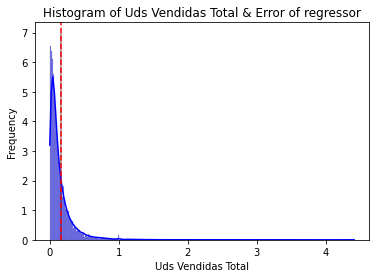

In [ ]:
hist_uds_error(y_test_pd, results_03['mean_test_neg_root_mean_squared_error'][bestm_index], results_03['std_test_neg_root_mean_squared_error'][bestm_index])

We need to get the best hyperparameters of the model so we can see the feature importance in the next step.

In [ ]:
max_depth, max_features, n_estimators = extract_variables(str(gscv_03.best_estimator_))

In the below graph, we can see the Feature importance that each variable has regarding the prediction of the target variable. The higher the value, the more important the feature.

In [ ]:
#Build model with final features
clf_03 = RandomForestRegressor(max_depth = max_depth, n_estimators = n_estimators, max_features = max_features, random_state = rndm_seed).fit(X_train_03, y_train_1D)

#Get feature importance
get_feature_importance(clf_03.feature_importances_, features_03)

,variable,coefficient
27,Number_of_sat&sun_std,0.243200
49,City_te_std,0.181000
48,Num_shops_per_art_std,0.112100
53,FECHA_PRIMERA_VENTA_day_of_week_te_std,0.046100
44,num_hol_daily_std,0.041100
45,days_overlap_postcovid_daily_std,0.037200
0,num_hol_std,0.034900
54,FECHA_PRIMERA_VENTA_day_of_year_te_std,0.031500
31,TEMP_MIN_std,0.023700
28,TEMP_AVG_std,0.018300


Now let´s take a look at the predictions of our model and the behaviour against the test dataset:

In [ ]:
y_pred_03 = clf_03.predict(data_test[features_03])

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test_pd, y_pred_03))

print("RMSE on the test dataset: ", round(rmse,5))

RMSE on the test dataset:  0.16149


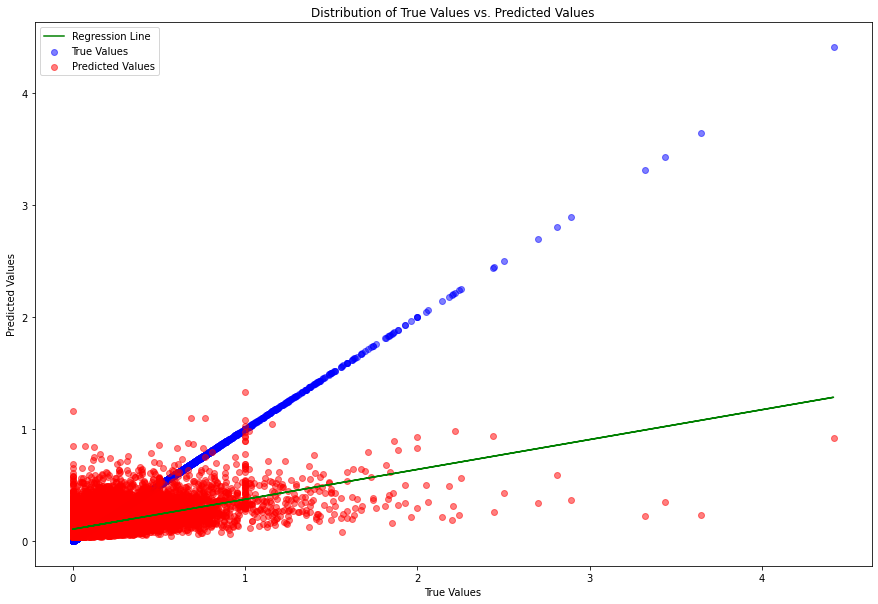

In [ ]:
plot_true_vs_pred_scatter(y_test_pd, y_pred_03)

Now the green line shows a big difference with the blue one, that goes in the same direction as the increase in the error. Clearly, the internal features are important for predicting our target variable.

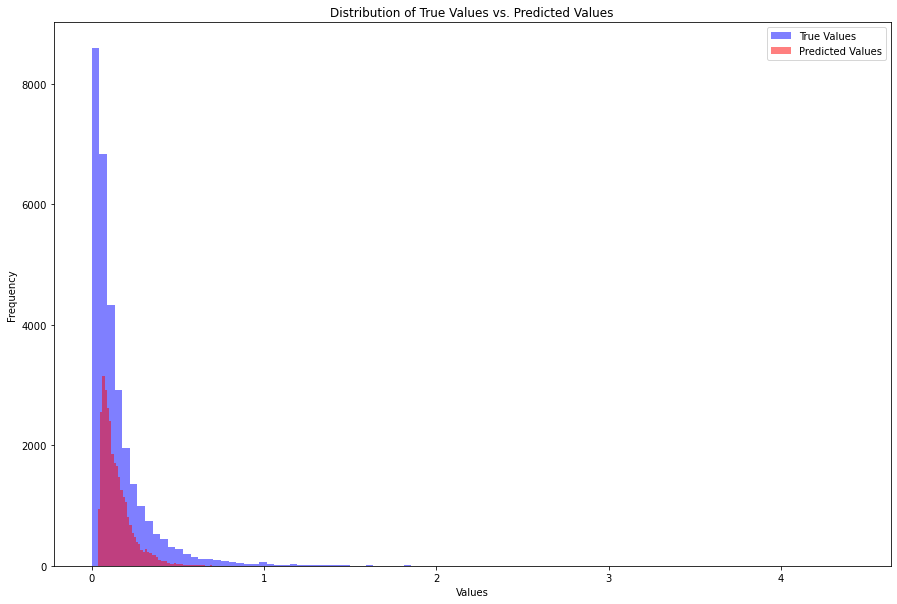

In [ ]:
plot_true_vs_pred_histogram(y_test_pd, y_pred_03)

Altough the distribution looks similar, mostly all our predictions are located between 0 and 1, showing that our predictions will have a huge error when the true values are not close to that range.

### Conclusions for Model 03

The third model eliminated all variables provided by INDITEX and kept only those created through feature engineering or external sources. The prediction was worst than previous models, but it identified the three most important created variables: 'Number_of_sat&sun', 'City_te', and 'Num_shops_per_art'. This model highlights the significance of these variables and the potential impact they can have on the model's performance, even though reducing the number of variables sometimes results in reduced accuracy. Further investigation of these important variables may lead to improved performance in future models.

<a id='3.4'></a>
### 3.4. Model 04: Non-Facturado model

This model will be run by taking out the variable "FACTURADO", which indicates the number of units requested to be sold in each store. Probably, this variable is a result of a prediction model done by Inditex (hence the importance that it has to predict UDS_VENDIDAS_TOTAL_daily). By taking it out, we would like to analyze the overshadowing effects it could have on the rest of the variables. 

Clearly, as this is very important variable for our model, we expect to have an increased error.

In [ ]:
## Get data to train model

# State features to use
features_04 = ['DIAS_HASTA_SALDO_std',
       'UDS_COMPRADAS_std', 'PRECIO_std', 'LATITUD_std', 'LONGITUD_std',
       'num_hol_std', 'Shops_in_city_std', 'Population_city_std',
       'GDP_Per_cap_city_std', 'Satelite_city_std', 'Summer_tourist_city_std',
       'habs_per_shop_city_std', 'Shops_in_country_std',
       'Population_country_std', 'GDP_Per_cap_country_std',
       'habs_per_shop_country_std', 'days_overlap_precovid_std',
       'days_overlap_strongcovid_std', 'days_overlap_mediumcovid_std',
       'days_overlap_postcovid_std', 'Jan_in_period_std', 'Feb_in_period_std',
       'Mar_in_period_std', 'Apr_in_period_std', 'May_in_period_std',
       'Jun_in_period_std', 'Jul_in_period_std', 'Aug_in_period_std',
       'Sep_in_period_std', 'Oct_in_period_std', 'Nov_in_period_std',
       'Dec_in_period_std', 'Number_of_sat&sun_std', 'TEMP_AVG_std',
       'TEMP_MED_std', 'TEMP_MAX_std', 'TEMP_MIN_std', 'PRCP_AVG_std',
       'PRCP_MED_std', 'PRCP_MAX_std', 'PRCP_MIN_std', 'PRCP_SUM_std',
       'WDSP_AVG_std', 'WDSP_MED_std', 'WDSP_MAX_std', 'WDSP_MIN_std',
       'num_hol_daily_std',
       'days_overlap_precovid_daily_std', 'days_overlap_strongcovid_daily_std',
       'days_overlap_mediumcovid_daily_std',
       'days_overlap_postcovid_daily_std', 'Number_of_sat&sun_daily_std',
       'PRCP_SUM_daily_std', 'Num_shops_per_art_std',
       'COD_COMPRADOR_1_ohe_std', 'COD_COMPRADOR_2_ohe_std',
       'COD_COMPRADOR_3_ohe_std', 'COD_COMPRADOR_4_ohe_std',
       'COD_COMPRADOR_5_ohe_std', 'MERCADO_1_ohe_std', 'MERCADO_2_ohe_std',
       'MERCADO_3_ohe_std', 'MERCADO_4_ohe_std', 'MERCADO_5_ohe_std',
       'MERCADO_6_ohe_std', 'MERCADO_7_ohe_std',
       'COD_TIPO_LOCALIZACION_1_ohe_std', 'COD_TIPO_LOCALIZACION_2_ohe_std',
       'COD_TIPO_LOCALIZACION_3_ohe_std', 'COD_TIPO_LOCALIZACION_4_ohe_std',
       'COD_TIPO_LOCALIZACION_5_ohe_std', 'COD_LOCALIZACION_te_std',
       'COD_TIPO_te_std', 'COD_SUBTIPO_te_std', 'COD_COLOR_te_std',
       'City_te_std', 'FECHA_PRIMERA_VENTA_year_te_std',
       'FECHA_PRIMERA_VENTA_month_te_std', 'FECHA_PRIMERA_VENTA_day_te_std',
       'FECHA_PRIMERA_VENTA_day_of_week_te_std',
       'FECHA_PRIMERA_VENTA_day_of_year_te_std',
       'FECHA_PRIMERA_VENTA_quarter_te_std',
       'FECHA_PRIMERA_VENTA_number_week_te_std',
       'FECHA_ULTIMA_VENTA_year_te_std', 'FECHA_ULTIMA_VENTA_month_te_std',
       'FECHA_ULTIMA_VENTA_day_te_std',
       'FECHA_ULTIMA_VENTA_day_of_week_te_std',
       'FECHA_ULTIMA_VENTA_day_of_year_te_std',
       'FECHA_ULTIMA_VENTA_quarter_te_std',
       'FECHA_ULTIMA_VENTA_number_week_te_std']

# Actually get features
X_train_04 = get_train_data(X_train, col_names, features_04)

This model has 90 features


The model is trained with the specified hyperparameters. The hyperparameter tuning is performed through a randomized search looking for the best hyperparameters using a specified scoring method and cross-validation method.

In [ ]:
## Train model

# Get start time of model
starttime_04 = datetime.now()

# Set parameters to test in the grid
paramsgrid_04 = {'random_state': [rndm_seed],
                 "n_estimators": [100, 500, 1000, 1500, 2000],
                 "max_depth": [5, 8, 10, 12, 15],
                 "max_features": ['sqrt', 0.2, 0.5, 0.7]}

# State model: Random Forest Regressor regression
model_04 = RandomForestRegressor(random_state=rndm_seed)

# State grid search
gscv_04 = RandomizedSearchCV(estimator=model_04,
                             param_distributions=paramsgrid_04,
                             scoring=scoring_method,
                             refit = 'neg_root_mean_squared_error',
                             cv = 5,
                             return_train_score=True, verbose = verbose_amount, n_jobs = n_jobs_use)

# Convert y_train to 1D array 
y_train_1D = np.ravel(y_train)

# Actually fit grid search
gscv_04.fit(X_train_04, y_train_1D)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=97),
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 8, 10, 12, 15],
                                        'max_features': ['sqrt', 0.2, 0.5, 0.7],
                                        'n_estimators': [100, 500, 1000, 1500,
                                                         2000],
                                        'random_state': [97]},
                   refit='neg_root_mean_squared_error', return_train_score=True,
                   scoring=['neg_root_mean_squared_error',
                            'neg_mean_absolute_percentage_error'],
                   verbose=2)

From the previous models trained, we will get the best results. This will help us understanding which of these is the best model and also will provide us the train and test score to compare them. 

In [ ]:
## Get results from models (MSE)

# Get results variable
results_04 = gscv_04.cv_results_

# Get best model index
bestm_index = gscv_04.best_index_

# Print results #std_test_neg_mean_absolute_percentage_error
print("The total runtime for the model was: " + str(datetime.now() - starttime_04))
print("\nThe final model is: " + str(gscv_04.best_estimator_))
print("\nThe mean error on training for the best model is: " +
      format(results_04['mean_train_neg_root_mean_squared_error'][bestm_index]*-1, '.3f') + " +/- " + 
      format(results_04['std_train_neg_root_mean_squared_error'][bestm_index]*-1, '.3f'))
print("\nThe mean error on validation for the best model is: " +
      format(results_04['mean_test_neg_root_mean_squared_error'][bestm_index]*-1, '.3f') + " +/- " + 
      format(results_04['std_test_neg_root_mean_squared_error'][bestm_index]*-1, '.3f'))

The total runtime for the model was: 7:54:26.367088

The final model is: RandomForestRegressor(max_depth=15, max_features=0.7, n_estimators=2000,
                      random_state=97)

The mean error on training for the best model is: 0.096 +/- -0.000

The mean error on validation for the best model is: 0.145 +/- -0.002


In order to see the error compared to the distribution of the target variable, we plot below the histogram of UDS_VENDIDAS_TOTAL. The red line is the error and the grey area is the confidence interval.

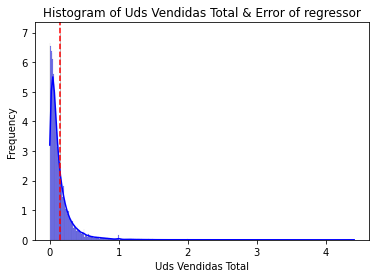

In [ ]:
hist_uds_error(y_test_pd, results_04['mean_test_neg_root_mean_squared_error'][bestm_index], results_04['std_test_neg_root_mean_squared_error'][bestm_index])

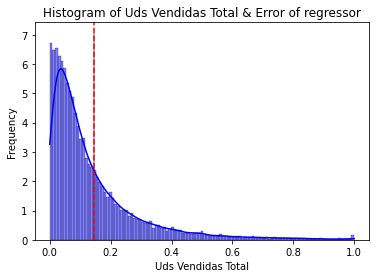

In [ ]:
hist_uds_error(y_test_pd.loc[y_test_pd["UDS_VENDIDAS_TOTAL_daily"]<=1], results_04['mean_test_neg_root_mean_squared_error'][bestm_index], results_04['std_test_neg_root_mean_squared_error'][bestm_index])

We need to get the best hyperparameters of the model so we can see the feature importance in the next step.

In [ ]:
max_depth, max_features, n_estimators = extract_variables(str(gscv_04.best_estimator_))

In the below graph, we can see the Feature importance that each variable has regarding the prediction of the target variable. The higher the value, the more important the feature.

In [ ]:
#Build model with final features
clf_04 = RandomForestRegressor(max_depth = max_depth, n_estimators = n_estimators, max_features = max_features, random_state = rndm_seed).fit(X_train_04, y_train_1D)

#Get feature importance
get_feature_importance(clf_04.feature_importances_, features_04)

,variable,coefficient
71,COD_LOCALIZACION_te_std,0.108900
1,UDS_COMPRADAS_std,0.095400
32,Number_of_sat&sun_std,0.093500
0,DIAS_HASTA_SALDO_std,0.085200
53,Num_shops_per_art_std,0.063000
74,COD_COLOR_te_std,0.047300
2,PRECIO_std,0.037600
73,COD_SUBTIPO_te_std,0.037500
80,FECHA_PRIMERA_VENTA_day_of_year_te_std,0.026600
50,days_overlap_postcovid_daily_std,0.025200


Now let´s take a look at the predictions of our model and the behaviour against the test dataset:

In [ ]:
y_pred_04 = clf_04.predict(data_test[features_04])

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test_pd, y_pred_04))

print("RMSE on the test dataset: ", round(rmse,5))

RMSE on the test dataset:  0.15049


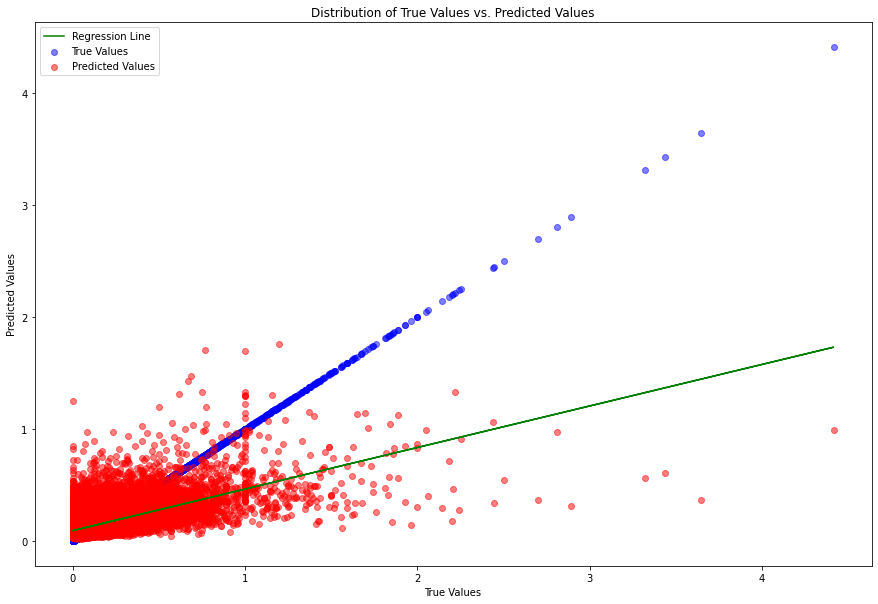

In [ ]:
plot_true_vs_pred_scatter(y_test_pd, y_pred_04)

Altough now the model is better than the previous one, the lines still are quite separated. Clearly, the importance of the feature FACTURADO is evident and crucial for our goods predictions.

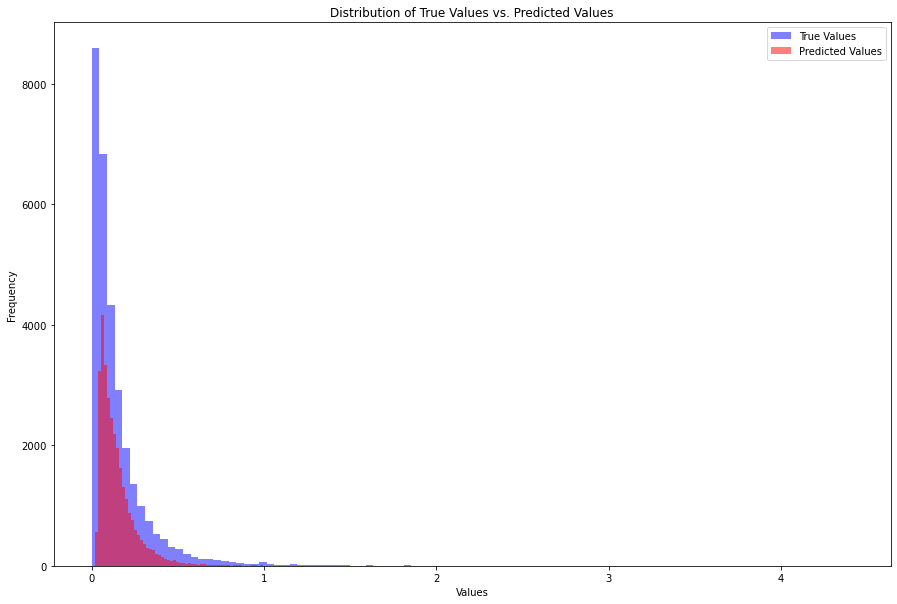

In [ ]:
plot_true_vs_pred_histogram(y_test_pd, y_pred_04)

Altough the distribution looks similar, mostly all our predictions are located between 0 and 1, showing that our predictions will have a huge error when the true values are not close to that range.

### Conclusions for Model 04

In the final model, we removed the 'FACTURADO' feature to assess the importance of other features. As we saw in Model 01, this feature had a significant impact on the model's performance and overshadowed the importance of other internal and external features.

Removing this feature resulted in a decrease in prediction results, but it provided valuable insights into the importance of the other features. Additionally, this model serves as a baseline for comparing future models and determining whether further investigation into XGBoost and LightGBM is necessary or if RandomForestRegressor is the optimal option.

<a id='4'></a>
## 4. Modeling: XGBoost

This code is training a machine learning model using XGBoost library in Python. It trains the model with XGBoost's XGBRegressor class and performs hyperparameter tuning using the RandomizedSearchCV class from scikit-learn library.

The **paramsgrid** dictionary sets the parameters to be tested in the grid search. It includes learning_rate, max_depth, min_child_weight, subsample, gamma and colsample_bytree. Here we inputed many diferent hyperparameter as in the following steps we will get the optimal ones.

The **model** is defined as an instance of XGBoost with the random_state parameter set to rndm_seed, defined when importing libraries.

The **gscv** is an instance of RandomizedSearchCV object that performs a randomized search for the best hyperparameters using a specified scoring method and a 5-fold cross-validation. The refit option is set to 'neg_root_mean_squared_error' which means the model will be re-trained on the entire training dataset with the best hyperparameters found. The grid search is performed with verbosity equal to verbose_amount and with the number of jobs specified by n_jobs_use.

Again, four different "metrics" will be reported through this process:

 - **Mean RMSE on train and validation** sets: this will be used to compare the performance of different models (mean RMSE on validation set) and to see whether the model is overfitting (mean RMSE on training vs validation sets).
 - **Standard deviation on training and validation** sets: to see how "confident" we are on the training and validation metrics.
 
Apart from this, the traing time will be recorded.

Finally, the y_train array is converted to a 1D array for computational issues. Then, the **gscv.fit** method fits the grid search on the training data X_train and y_train_1D.

<a id='4.1'></a>
### 4.1 Model 05: Non-Facturado model

Now let´s try this last model with another tree-based algorithm: XGBoost.

In [ ]:
## Get data to train model

# State features to use
features_05 = ['DIAS_HASTA_SALDO_std',
       'UDS_COMPRADAS_std', 'PRECIO_std', 'LATITUD_std', 'LONGITUD_std',
       'num_hol_std', 'Shops_in_city_std', 'Population_city_std',
       'GDP_Per_cap_city_std', 'Satelite_city_std', 'Summer_tourist_city_std',
       'habs_per_shop_city_std', 'Shops_in_country_std',
       'Population_country_std', 'GDP_Per_cap_country_std',
       'habs_per_shop_country_std', 'days_overlap_precovid_std',
       'days_overlap_strongcovid_std', 'days_overlap_mediumcovid_std',
       'days_overlap_postcovid_std', 'Jan_in_period_std', 'Feb_in_period_std',
       'Mar_in_period_std', 'Apr_in_period_std', 'May_in_period_std',
       'Jun_in_period_std', 'Jul_in_period_std', 'Aug_in_period_std',
       'Sep_in_period_std', 'Oct_in_period_std', 'Nov_in_period_std',
       'Dec_in_period_std', 'Number_of_sat&sun_std', 'TEMP_AVG_std',
       'TEMP_MED_std', 'TEMP_MAX_std', 'TEMP_MIN_std', 'PRCP_AVG_std',
       'PRCP_MED_std', 'PRCP_MAX_std', 'PRCP_MIN_std', 'PRCP_SUM_std',
       'WDSP_AVG_std', 'WDSP_MED_std', 'WDSP_MAX_std', 'WDSP_MIN_std',
       'num_hol_daily_std',
       'days_overlap_precovid_daily_std', 'days_overlap_strongcovid_daily_std',
       'days_overlap_mediumcovid_daily_std',
       'days_overlap_postcovid_daily_std', 'Number_of_sat&sun_daily_std',
       'PRCP_SUM_daily_std', 'Num_shops_per_art_std',
       'COD_COMPRADOR_1_ohe_std', 'COD_COMPRADOR_2_ohe_std',
       'COD_COMPRADOR_3_ohe_std', 'COD_COMPRADOR_4_ohe_std',
       'COD_COMPRADOR_5_ohe_std', 'MERCADO_1_ohe_std', 'MERCADO_2_ohe_std',
       'MERCADO_3_ohe_std', 'MERCADO_4_ohe_std', 'MERCADO_5_ohe_std',
       'MERCADO_6_ohe_std', 'MERCADO_7_ohe_std',
       'COD_TIPO_LOCALIZACION_1_ohe_std', 'COD_TIPO_LOCALIZACION_2_ohe_std',
       'COD_TIPO_LOCALIZACION_3_ohe_std', 'COD_TIPO_LOCALIZACION_4_ohe_std',
       'COD_TIPO_LOCALIZACION_5_ohe_std', 'COD_LOCALIZACION_te_std',
       'COD_TIPO_te_std', 'COD_SUBTIPO_te_std', 'COD_COLOR_te_std',
       'City_te_std', 'FECHA_PRIMERA_VENTA_year_te_std',
       'FECHA_PRIMERA_VENTA_month_te_std', 'FECHA_PRIMERA_VENTA_day_te_std',
       'FECHA_PRIMERA_VENTA_day_of_week_te_std',
       'FECHA_PRIMERA_VENTA_day_of_year_te_std',
       'FECHA_PRIMERA_VENTA_quarter_te_std',
       'FECHA_PRIMERA_VENTA_number_week_te_std',
       'FECHA_ULTIMA_VENTA_year_te_std', 'FECHA_ULTIMA_VENTA_month_te_std',
       'FECHA_ULTIMA_VENTA_day_te_std',
       'FECHA_ULTIMA_VENTA_day_of_week_te_std',
       'FECHA_ULTIMA_VENTA_day_of_year_te_std',
       'FECHA_ULTIMA_VENTA_quarter_te_std',
       'FECHA_ULTIMA_VENTA_number_week_te_std']

# Actually get features
X_train_05 = get_train_data(X_train, col_names, features_05)

This model has 90 features


In [ ]:
## Train model

# Get start time of model
starttime_05 = datetime.now()

# Set parameters to test in the grid
paramsgrid_05 = {
    'learning_rate': np.arange(0.05, 0.31, 0.05),
    'max_depth': [3, 4, 5, 6, 7, 8, 9],
    'min_child_weight': [1, 2, 3, 4],
    'subsample': np.arange(0.5, 1.0, 0.1),
    'gamma': np.arange(0, 0.5, 0.1),
    'colsample_bytree': np.arange(0.5, 1.0, 0.1)}

# State model: Random Forest Regressor regression
model_05 = xgb.XGBRegressor(random_state=rndm_seed)

# State grid search
gscv_05 = RandomizedSearchCV(estimator=model_05,
                             param_distributions=paramsgrid_05,
                             scoring=scoring_method,
                             refit = 'neg_root_mean_squared_error',
                             cv = 5, n_iter=100,
                             return_train_score=True, verbose = verbose_amount, n_jobs = n_jobs_use)

# Convert y_train to 1D array 
y_train_1D = np.ravel(y_train)

# Actually fit grid search
gscv_05.fit(X_train_05, y_train_1D)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          m...
                   param_distributions={'colsample_bytree': array([0.5, 0.6, 0.7, 0.8, 0.9]),
            

From the previous models trained, we will get the best results. This will help us understanding which of these is the best model and also will provide us the train and test score to compare them. 

In [ ]:
## Get results from models (MSE) # CORRER DE NUEVO ESTO!

# Get results variable
results_05 = gscv_05.cv_results_

# Get best model index
bestm_index = gscv_05.best_index_

# Print results #std_test_neg_mean_absolute_percentage_error
print("The total runtime for the model was: " + str(datetime.now() - starttime_05))
print("\nThe final model is: " + str(gscv_05.best_estimator_))
print("\nThe mean error on training for the best model is: " +
      format(results_05['mean_train_neg_root_mean_squared_error'][bestm_index]*-1, '.3f') + " +/- " + 
      format(results_05['std_train_neg_root_mean_squared_error'][bestm_index]*-1, '.3f'))
print("\nThe mean error on validation for the best model is: " +
      format(results_05['mean_test_neg_root_mean_squared_error'][bestm_index]*-1, '.3f') + " +/- " + 
      format(results_05['std_test_neg_root_mean_squared_error'][bestm_index]*-1, '.3f'))

The total runtime for the model was: 8:52:24.887468

The final model is: XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.7999999999999999, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=0.0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=9, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=97, reg_alpha=0, reg_lambda=1, ...)

The mean error on training for the best model is: 0.110 +/- -0.001

The mean error on validation for the best model is: 0.141 +/- -0.002


In order to see the error compared to the distribution of the target variable, we plot below the histogram of UDS_VENDIDAS_TOTAL. The red line is the error and the grey area is the confidence interval.

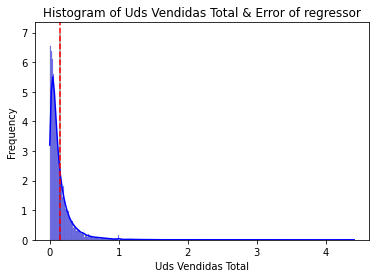

In [ ]:
hist_uds_error(y_test_pd, results_05['mean_test_neg_root_mean_squared_error'][bestm_index], results_05['std_test_neg_root_mean_squared_error'][bestm_index])

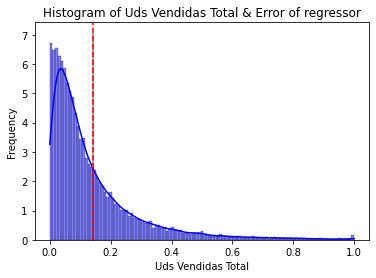

In [ ]:
hist_uds_error(y_test_pd.loc[y_test_pd["UDS_VENDIDAS_TOTAL_daily"]<=1], results_05['mean_test_neg_root_mean_squared_error'][bestm_index], results_05['std_test_neg_root_mean_squared_error'][bestm_index])

We need to get the best hyperparameters of the model so we can see the feature importance in the next step.

In [ ]:
max_depth, max_features, n_estimators = extract_variables(str(gscv_05.best_estimator_))

In the below graph, we can see the Feature importance that each variable has regarding the prediction of the target variable. The higher the value, the more important the feature.

In [ ]:
#Build model with final features
clf_05 = xgb.XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None, colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7999999999999999, early_stopping_rounds=None, enable_categorical=False, eval_metric=None, gamma=0.0, gpu_id=-1, grow_policy='depthwise', importance_type=None, interaction_constraints='', learning_rate=0.1, max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=9, max_leaves=0, min_child_weight=1, monotone_constraints='()', n_estimators=100, n_jobs=0, num_parallel_tree=1, predictor='auto', reg_alpha=0, reg_lambda=1, random_state = rndm_seed).fit(X_train_05, y_train_1D)

#Get feature importance
get_feature_importance(clf_05.feature_importances_, features_05)

,variable,coefficient
32,Number_of_sat&sun_std,0.147300
71,COD_LOCALIZACION_te_std,0.050600
30,Nov_in_period_std,0.045000
76,FECHA_PRIMERA_VENTA_year_te_std,0.033400
75,City_te_std,0.029700
79,FECHA_PRIMERA_VENTA_day_of_week_te_std,0.028200
0,DIAS_HASTA_SALDO_std,0.026200
50,days_overlap_postcovid_daily_std,0.020100
56,COD_COMPRADOR_3_ohe_std,0.016700
16,days_overlap_precovid_std,0.015900


Now let´s take a look at the predictions of our model and the behaviour against the test dataset:

In [ ]:
y_pred_05 = clf_05.predict(data_test[features_05])

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test_pd, y_pred_05))

print("RMSE on the test dataset: ", round(rmse,5))

RMSE on the test dataset:  0.14665


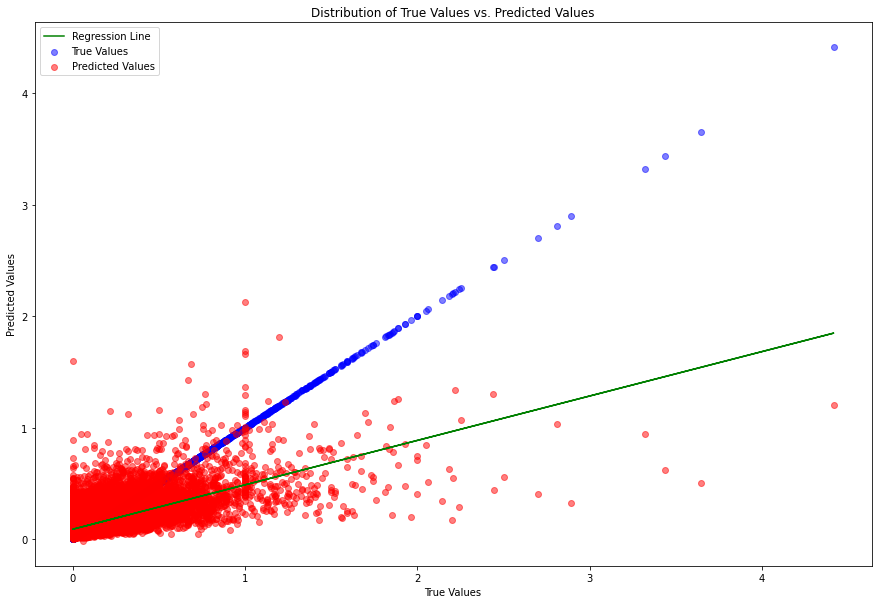

In [ ]:
plot_true_vs_pred_scatter(y_test_pd, y_pred_05)

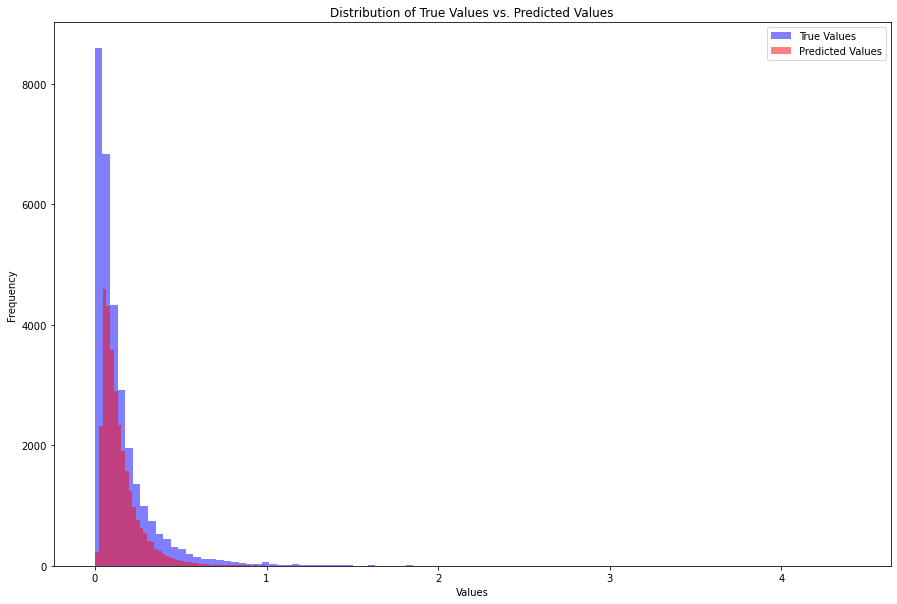

In [ ]:
plot_true_vs_pred_histogram(y_test_pd, y_pred_05)

Both graphs does not show relevant differences from the Model 04.

### Conclusions for Model 05

The XGBoost model was compared to Model 04 and both models showed similar results in terms of RMSE and feature importance. While the prediction of Model 04 was slightly better, the XGBoost model had a significantly higher computational cost, making it less attractive for further investigation. Given these factors, we decided to discontinue our exploration of the XGBoost model and concentrate our efforts on other options using the RandomForestRegressor.

<a id='5'></a>
## 5. Modeling: LightGBM

This code is training a machine learning model using LightGBM library in Python. It trains the model with LightGBM's LGBMRegressor class and performs hyperparameter tuning using the RandomizedSearchCV class from scikit-learn library.

The **paramsgrid** dictionary sets the parameters to be tested in the grid search. It includes random_state, boosting_type, n_estimators, max_depth, num_leaves, learning_rate and feature_fraction. Here we inputed many diferent hyperparameter as in the following steps we will get the optimal ones.

The **model** is defined as an instance of XGBoost with the random_state parameter set to rndm_seed, defined when importing libraries.

The **gscv** is an instance of RandomizedSearchCV object that performs a randomized search for the best hyperparameters using a specified scoring method and cross-validation method (5-fold cross-validation). The refit option is set to 'neg_root_mean_squared_error' which means the model will be re-trained on the entire training dataset with the best hyperparameters found. The grid search is performed with verbosity verbose_amount and with the number of jobs specified by n_jobs_use.

Similar to previous cases, four different "metrics" will be reported through this process:

 - **Mean RMSE on train and validation** sets: this will be used to compare the performance of different models (mean RMSE on validation set) and to see whether the model is overfitting (mean RMSE on training vs validation sets).
 - **Standard deviation on training and validation** sets: to see how "confident" we are on the training and validation metrics.
Apart from this, the traing time will be recorded.

Finally, the y_train array is converted to a 1D array for computational issues. Then, the **gscv.fit** method fits the grid search on the training data X_train and y_train_1D.

<a id='5.1'></a>
### 5.1 Model 06: Non-Facturado model

Now let´s try this last model with another tree-based algorithm: LightGBM.

In [ ]:
## Get data to train model

# State features to use
features_06 = ['DIAS_HASTA_SALDO_std', 'PRECIO_std', 'LATITUD_std', 'LONGITUD_std',
       'num_hol_std', 'Shops_in_city_std', 'Population_city_std',
       'GDP_Per_cap_city_std', 'Satelite_city_std', 'Summer_tourist_city_std',
       'habs_per_shop_city_std', 'Shops_in_country_std',
       'Population_country_std', 'GDP_Per_cap_country_std',
       'habs_per_shop_country_std', 'days_overlap_precovid_std',
       'days_overlap_strongcovid_std', 'days_overlap_mediumcovid_std',
       'days_overlap_postcovid_std', 'Jan_in_period_std', 'Feb_in_period_std',
       'Mar_in_period_std', 'Apr_in_period_std', 'May_in_period_std',
       'Jun_in_period_std', 'Jul_in_period_std', 'Aug_in_period_std',
       'Sep_in_period_std', 'Oct_in_period_std', 'Nov_in_period_std',
       'Dec_in_period_std', 'Number_of_sat&sun_std', 'TEMP_AVG_std',
       'TEMP_MED_std', 'TEMP_MAX_std', 'TEMP_MIN_std', 'PRCP_AVG_std',
       'PRCP_MED_std', 'PRCP_MAX_std', 'PRCP_MIN_std', 'PRCP_SUM_std',
       'WDSP_AVG_std', 'WDSP_MED_std', 'WDSP_MAX_std', 'WDSP_MIN_std', 'num_hol_daily_std',
       'days_overlap_precovid_daily_std', 'days_overlap_strongcovid_daily_std',
       'days_overlap_mediumcovid_daily_std',
       'days_overlap_postcovid_daily_std', 'Number_of_sat&sun_daily_std',
       'PRCP_SUM_daily_std', 'Num_shops_per_art_std',
       'COD_COMPRADOR_1_ohe_std', 'COD_COMPRADOR_2_ohe_std',
       'COD_COMPRADOR_3_ohe_std', 'COD_COMPRADOR_4_ohe_std',
       'COD_COMPRADOR_5_ohe_std', 'MERCADO_1_ohe_std', 'MERCADO_2_ohe_std',
       'MERCADO_3_ohe_std', 'MERCADO_4_ohe_std', 'MERCADO_5_ohe_std',
       'MERCADO_6_ohe_std', 'MERCADO_7_ohe_std',
       'COD_TIPO_LOCALIZACION_1_ohe_std', 'COD_TIPO_LOCALIZACION_2_ohe_std',
       'COD_TIPO_LOCALIZACION_3_ohe_std', 'COD_TIPO_LOCALIZACION_4_ohe_std',
       'COD_TIPO_LOCALIZACION_5_ohe_std', 'COD_LOCALIZACION_te_std',
       'COD_TIPO_te_std', 'COD_SUBTIPO_te_std', 'COD_COLOR_te_std',
       'City_te_std', 'FECHA_PRIMERA_VENTA_year_te_std',
       'FECHA_PRIMERA_VENTA_month_te_std', 'FECHA_PRIMERA_VENTA_day_te_std',
       'FECHA_PRIMERA_VENTA_day_of_week_te_std',
       'FECHA_PRIMERA_VENTA_day_of_year_te_std',
       'FECHA_PRIMERA_VENTA_quarter_te_std',
       'FECHA_PRIMERA_VENTA_number_week_te_std',
       'FECHA_ULTIMA_VENTA_year_te_std', 'FECHA_ULTIMA_VENTA_month_te_std',
       'FECHA_ULTIMA_VENTA_day_te_std',
       'FECHA_ULTIMA_VENTA_day_of_week_te_std',
       'FECHA_ULTIMA_VENTA_day_of_year_te_std',
       'FECHA_ULTIMA_VENTA_quarter_te_std',
       'FECHA_ULTIMA_VENTA_number_week_te_std']

features_drop_06 = ['FACTURADO_std', 'UDS_COMPRADAS_std', 'FACTURADO_daily_std']

# Actually get features
X_train_06 = get_train_data(X_train, col_names, features_06)

This model has 89 features


The model is trained with the specified hyperparameters. The hyperparameter tuning is performed through a randomized search looking for the best hyperparameters using a specified scoring method and cross-validation method.

In [ ]:
## Train model

# Get start time of model
starttime_06 = datetime.now()

# Set parameters to test in the grid
paramsgrid_06 = {'random_state': [rndm_seed],
                 'boosting_type': ['gbdt', 'dart'],
                 "n_estimators": [100, 500, 1000, 1500, 2000],
                 "max_depth": [5, 8, 10, 12, 15],
                 "num_leaves": [31, 63, 127],
                 "learning_rate": [0.1, 0.05, 0.01, 0.005, 0.001],
                 "feature_fraction": [0.2, 0.5, 0.7, 1.0]}

# State model: Random Forest Regressor regression
model_06 = lgb.LGBMRegressor(random_state=rndm_seed)

# State grid search
gscv_06 = RandomizedSearchCV(estimator=model_06,
                             param_distributions=paramsgrid_06,
                             scoring=scoring_method,
                             refit='neg_root_mean_squared_error',
                             cv=5,
                             return_train_score=True, verbose=verbose_amount, n_jobs=n_jobs_use)

# Convert y_train to 1D array 
y_train_1D = np.ravel(y_train)

# Actually fit grid search
gscv_06.fit(X_train_06, y_train_1D)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


RandomizedSearchCV(cv=5, estimator=LGBMRegressor(random_state=97), n_jobs=-1,
                   param_distributions={'boosting_type': ['gbdt', 'dart'],
                                        'feature_fraction': [0.2, 0.5, 0.7,
                                                             1.0],
                                        'learning_rate': [0.1, 0.05, 0.01,
                                                          0.005, 0.001],
                                        'max_depth': [5, 8, 10, 12, 15],
                                        'n_estimators': [100, 500, 1000, 1500,
                                                         2000],
                                        'num_leaves': [31, 63, 127],
                                        'random_state': [97]},
                   refit='neg_root_mean_squared_error', return_train_score=True,
                   scoring=['neg_root_mean_squared_error',
                            'neg_mean_absolute_percentage_error'],
 

From the previous models trained, we will get the best results. This will help us understanding which of these is the best model and also will provide us the train and test score to compare them. 

In [ ]:
## Get results from models (MSE)

# Get results variable
results_06 = gscv_06.cv_results_

# Get best model index
bestm_index = gscv_06.best_index_

# Print results #std_test_neg_mean_absolute_percentage_error
print("The total runtime for the model was: " + str(datetime.now() - starttime_06))
print("\nThe final model is: " + str(gscv_06.best_estimator_))
print("\nThe mean error on training for the best model is: " +
      format(results_06['mean_train_neg_root_mean_squared_error'][bestm_index]*-1, '.3f') + " +/- " + 
      format(results_06['std_train_neg_root_mean_squared_error'][bestm_index]*-1, '.3f'))
print("\nThe mean error on validation for the best model is: " +
      format(results_06['mean_test_neg_root_mean_squared_error'][bestm_index]*-1, '.3f') + " +/- " + 
      format(results_06['std_test_neg_root_mean_squared_error'][bestm_index]*-1, '.3f'))

The total runtime for the model was: 0:38:09.256824

The final model is: LGBMRegressor(feature_fraction=0.5, max_depth=12, n_estimators=2000,
              random_state=97)

The mean error on training for the best model is: 0.097 +/- -0.000

The mean error on validation for the best model is: 0.141 +/- -0.002


In order to see the error compared to the distribution of the target variable, we plot below the histogram of UDS_VENDIDAS_TOTAL. The red line is the error and the grey area is the confidence interval.

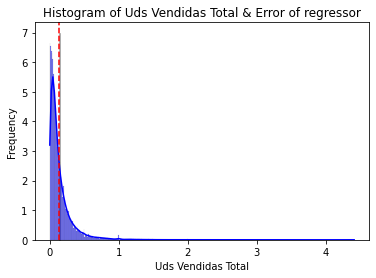

In [ ]:
hist_uds_error(y_test_pd, results_06['mean_test_neg_root_mean_squared_error'][bestm_index], results_06['std_test_neg_root_mean_squared_error'][bestm_index])

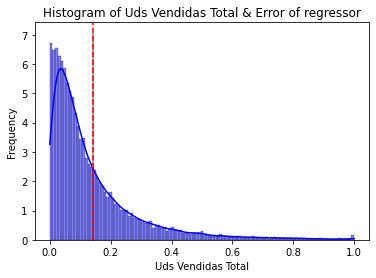

In [ ]:
hist_uds_error(y_test_pd.loc[y_test_pd["UDS_VENDIDAS_TOTAL_daily"]<=1], results_06['mean_test_neg_root_mean_squared_error'][bestm_index], results_06['std_test_neg_root_mean_squared_error'][bestm_index])

We need to get the best hyperparameters of the model so we can see the feature importance in the next step.

In [ ]:
max_depth, max_features, n_estimators = extract_variables(str(gscv_06.best_estimator_))

In the below graph, we can see the Feature importance that each variable has regarding the prediction of the target variable. The higher the value, the more important the feature.

In [ ]:
#Build model with final features
clf_06 = lgb.LGBMRegressor(feature_fraction=0.5, max_depth=12, n_estimators=2000,random_state=97).fit(X_train_06, y_train_1D)

#Get feature importance
get_feature_importance(clf_06.feature_importances_, features_06)

,variable,coefficient
73,COD_COLOR_te_std,4140
52,Num_shops_per_art_std,3760
72,COD_SUBTIPO_te_std,2827
0,DIAS_HASTA_SALDO_std,2667
1,PRECIO_std,2405
50,Number_of_sat&sun_daily_std,2241
79,FECHA_PRIMERA_VENTA_day_of_year_te_std,2240
70,COD_LOCALIZACION_te_std,1977
71,COD_TIPO_te_std,1671
77,FECHA_PRIMERA_VENTA_day_te_std,1630


Now let´s take a look at the predictions of our model and the behaviour against the test dataset:

In [ ]:
y_pred_06 = clf_06.predict(data_test[features_06])

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test_pd, y_pred_06))

print("RMSE on the test dataset: ", round(rmse,5))

RMSE on the test dataset:  0.14343


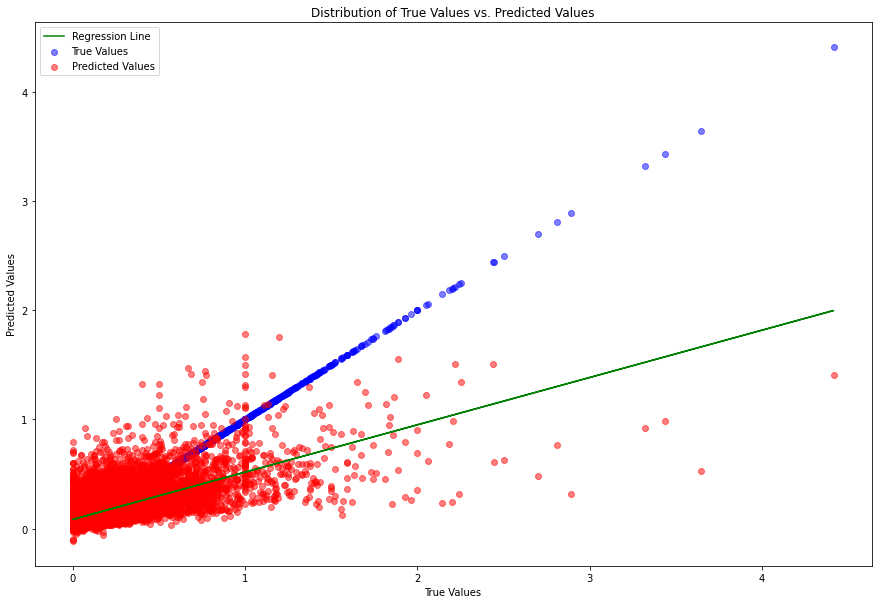

In [ ]:
plot_true_vs_pred_scatter(y_test_pd, y_pred_06)

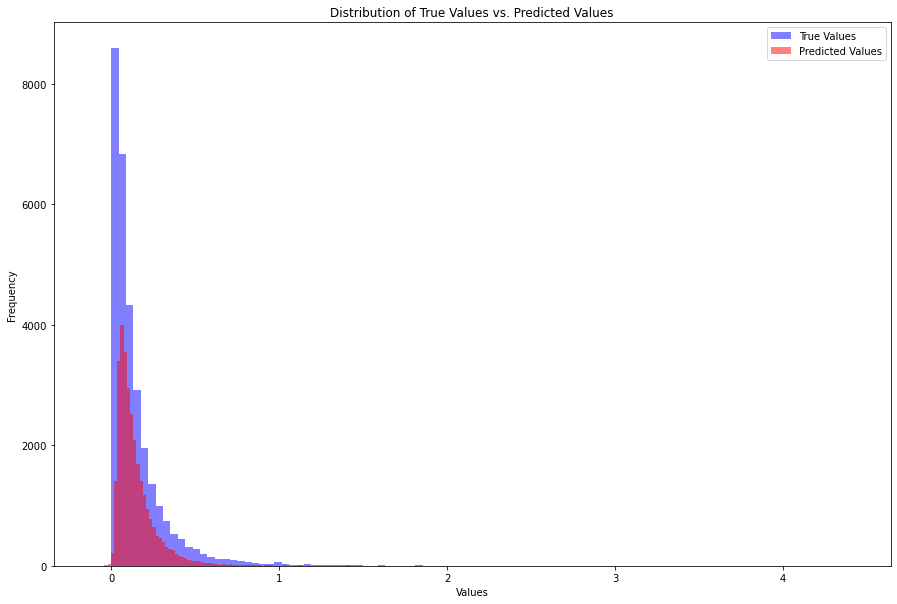

In [ ]:
plot_true_vs_pred_histogram(y_test_pd, y_pred_06)

Both graphs does not show relevant differences from the Model 05.

### Conclusions for Model 06

This LightGBM model, much like Models 04 and 05, has produced results that are highly comparable in terms of both RMSE and feature importance. Despite its low computational cost and ease of interaction, we have decided to discontinue any further investigation with this model and concentrate our efforts on exploring alternative options utilizing RandomForestRegressor.

<a id='6'></a>
### 6. Final Conclusions

Looking at the RMSE error, we can confidently say that our final model is the first one. One crucial characteristic of this metric is that keeps the measure on the same units as the target variable. As UDS_VENDIDAS_TOTAL was transformed into daily format during the pre-modeling stage, in order to understand the RMSE obtained on test (0.08429) we need to undo the mentioned transformation by multiplying this result by the average of the column DIAS_HASTA_SALDO. This calculation shows that our prediction, on average, commits a mistake of only +/- 8 units. If we take out the variable FACTURADO, the models showed that this error doubles: +/- 16. The importance of this variable is clear. 

Moreover, some features that also resulted to be essential through the models were:

- UDS_COMPRADAS: the total amount of units at disposal is also important and probably it goes in a similar direction as the importance of FACTURADO. 
- COD_LOCALIZACION: this implies that the type of locale where the article is sold, is important for predicting sales. This could also be used in future business decisions for Inditex.
- Num_shops_per_art: this variable shows that if we have an article that is sold in several locations, must have high sales, showing that probably, the article is popular and hence the high demand.
- Number_of_sat&sun_daily: it is not hard to understand that on Saturdays and on Sundays, the sales are going to be higher than on any weekday (with the exception of holidays). If we have more weekends during the period for which the product has been sold, the number of sales is going to be higher. This shows that starting the sale of a product on a Friday or a Monday can have a significant impact on the total amount of units sold.

With regards to external variables, our analysis showed that while their inclusion improved the model as they were utilized by the RandomForest, their significance was not as significant as previously assumed. The most important among all of them were: 

- TEMP_AVERAGE: we could argue that low temperatures can affect the sales of winter clothes, for example, indicating that it could be important for predicting our target variable.
- City_te: this variable indicates whether the locale is in a city or not. Again, we can expect a higher affluent of consumers in a city than in a town or village. 

Finally, by examining the histograms and scatter plots, we can see that Model 01 presented the closest distribution to the test dataset.

### 7. Annex <a id='7'></a> 
#### Permutation Importance

The results for the permutation importance were quite similar to the current method used. We decided to leave it here just as a reference of how did we used it.

In [ ]:
#Build model with final features
#y_train = np.ravel(y_train)
#clf = RandomForestRegressor(max_depth=30, n_estimators=70, random_state=rndm_seed).fit(X_train_01, y_train)

#Get feature importance
#result = permutation_importance(clf, X_train_01, y_train, n_repeats=3, random_state=0)
#sorted_idx = np.argsort(result.importances.mean(axis=1))[::-1]

# Print the features in ascending order
#for idx in sorted_idx:
#    print(f'{features_01[idx]}: {result.importances[idx].mean()}')